# Importamos las librerias necesarias
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import random
import keras

2024-05-03 21:22:22.575190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 21:22:22.576563: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 21:22:22.583330: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 21:22:22.675313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 21:22:24.596328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# 1. Preparamos los datos
---

In [2]:
# Cargamos los datos
fish_data = np.load('data/fish.npy')
car_data = np.load('data/car.npy')
tree_data = np.load('data/tree.npy')

In [3]:
# Obtenemos una muestra
NUM_SAMPLE_DATA = 2000
fish_sample = np.array(random.sample(list(fish_data),NUM_SAMPLE_DATA))
car_sample = np.array(random.sample(list(car_data),NUM_SAMPLE_DATA))
tree_sample = np.array(random.sample(list(tree_data),NUM_SAMPLE_DATA))

# Concatenamos nuestros datos dependientes
X = np.concatenate((fish_sample, car_sample, tree_sample), axis=0)
# Normalizamos los valores de los datos, escalamos pixeles en el rango de 0 a 1.
X = X / 255.0

#X_ = X.reshape(-1, 28, 28)

#X = X / 255
X = X.reshape(-1, 28, 28)
# Tres clases: fish (0), car (1) y tree (2)
y = np.concatenate((np.zeros(fish_sample.shape[0]), np.ones(car_sample.shape[0]), np.full(tree_sample.shape[0], 2)))

print(X.shape, y.shape)

(6000, 28, 28) (6000,)


# 2. Obtenemos los datos de entrenamiento y testing
---

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [5]:
# Vemos las dimensiones
y_train.shape

(4800,)

In [6]:
# Ajustamos las dimensiones de las imágenes
if X_train.ndim == 3:
    X_train = X_train[...,None]
    X_test = X_test[..., None]
    print(X_train.shape, X_test.shape)

(4800, 28, 28, 1) (1200, 28, 28, 1)


# 3. Definimos el modelo
---

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

bs = 16
lr = 0.0005
size = (28, 28)

#Espacio de busqueda
#Cantidad Filtros: 32, 64, 128, 256
#Tamaño del Filtro: 3, 5, 7
#Activaciones: 'relu', 'sigmoid', 'tanh'
#Unidades Dense: 128, 256, 100..
#lr: 0.001, 0.0001, 0.00001, etc
#bs: 8, 16, 32...

model = Sequential([Conv2D(32, 3, activation='relu', input_shape=(*size,1), padding='same'),
                    MaxPool2D(),
                    Conv2D(64, 3, activation='relu', padding='same'),
                    MaxPool2D(),
                    Conv2D(128, 3, activation='relu', padding='same'),
                    MaxPool2D(),
                    Flatten(),
                    Dense(128, activation='relu'), #modificar!
                    Dense(10, activation='softmax')]) #no modificar

model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# La pérdida 'sparse_categorical_crossentropy' realiza automaticamente la conversión
# del target a one-hot encoding.

model.summary()

/home/guisa17/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Entrenamiento
---

In [8]:
log = model.fit(X_train, y_train, 
                batch_size=30, 
                epochs=50, 
                validation_data=(X_test, y_test)
    )

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6019 - loss: 1.2954 - val_accuracy: 0.7758 - val_loss: 0.4639
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8568 - loss: 0.3772 - val_accuracy: 0.9058 - val_loss: 0.2884
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9175 - loss: 0.2429 - val_accuracy: 0.9167 - val_loss: 0.2757
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9268 - loss: 0.2155 - val_accuracy: 0.9083 - val_loss: 0.2700
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9390 - loss: 0.1987 - val_accuracy: 0.9117 - val_loss: 0.2707
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9428 - loss: 0.1858 - val_accuracy: 0.9367 - val_loss: 0.2110
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9460 - loss: 0.1632 - val_accuracy: 0.9442 - val_loss: 0.2057
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9382 - loss: 0.1796 - val_accu

In [9]:
def show_results(model, log):
    loss, acc = model.evaluate(X_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    val_loss = log.history['val_loss']
    val_acc = log.history['val_accuracy']
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['accuracy'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('acc')
    for ax in axes: ax.legend()

Loss     = 0.1430
Accuracy = 0.9550


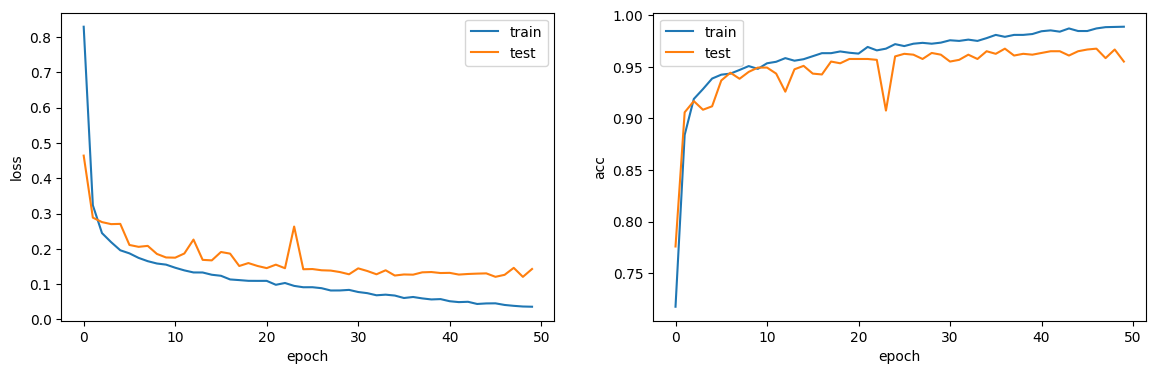

In [10]:
show_results(model, log)
# bs -> 16
# 10 categorias -> [0, 1, ..., 9]
# bs -> [0, 0, 0, ... 0, 1, 2, 9, 8, 4]

In [11]:
predicciones = model.predict([X_test])
X_test.shape[0]

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


1200

# 5. Probando el modelo
---

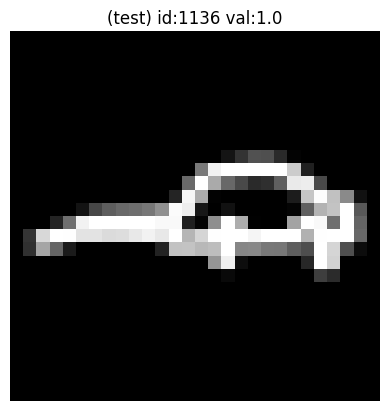

In [12]:
idx = np.random.choice(X_test.shape[0], 1)[0]
im = X_test[idx]
label = y_test[idx]
plt.title('(test) id:{} val:{}'.format(idx, label ))
plt.axis('off')
plt.imshow(im[:,:,0], cmap='gray')
plt.show()

# 6. Usando el modelo
---

In [13]:
salida = model.predict(im[None,:,:,:])[0]
predicciones = model.predict(im[None,:,:,:])[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [ ]:
plt.figure()
plt.title("Predicción: {} Label: {}".format(salida.argmax(), label ))
plt.ylabel("Probabilidad")
plt.xlabel("Dígito")
plt.ylim([0,1])
plt.bar(np.arange(10), salida)
plt.plot()

IndexError: index 20 is out of bounds for axis 0 with size 10

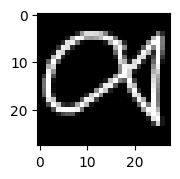

In [14]:
plt.figure(figsize=(10, 10))
for i in range(20,30):
    plt.subplot(5, 2, i - 19)
    plt.imshow(X_test[i], cmap='gray')
    plt.title("Prediccion: {}, Actual: {}".format(np.argmax(predicciones[i]), y_test[i]))
    plt.axis('off')
plt.show()

# 7. Guardamos el modelo
---

In [ ]:
# Guardar el Modelo
model.save('modelov2.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('modelov2.h5')

In [ ]:
!pip3 install tensorflowjs

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!tensorflowjs_converter --input_format keras modelo_1.h5 modelo_salida

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


2024-05-03 14:34:06.752518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file
